# Natural Language Processing: Sentiment Analysis

**Author**: Albane Colmenares <br>
**Date**: December 12th, 2023 <br>
___________________________________________________________________________

### <u>Table of Content</u>
**1. Overview**<br>
**2. Business Understanding**<br>
**3. Data Understanding**<br>
**4. Data Preparation**<br>
**5. Modeling**<br>
**6. Evaluation**<br>
**7. Findings & Recommendations**<br>
**8. Limits & Next Steps**<br>

## 1. Overview

This notebook examines tweets about several brands and products and predicts whether the sentiment of the short text is positive, negative or neutral. <br>
The organization of this notebook follows the CRoss Industry Standard Process for Data Mining (CRISP-DM) is a process model that serves as the base for a data science process.

Text Text Text Text Text Text 

## 2. Business Understanding

Business and data understanding: *what kind of data are you using, and what makes it well-suited for the business problem?*
* You do not need to include any data visualizations in your summary, but consider including relevant descriptive statistics

Text Text Text Text Text Text 

Text Text Text Text Text Text 

## 3. Data Understanding

**Data Source**

The data comes from CrowdFlower via [data.world](https://data.world/crowdflower/brands-and-product-emotions). 


------------- REPHRASE THIS ------------- 

*Human raters rated the sentiment in over 9,000 Tweets as positive, negative, or neither.*

------------- REPHRASE THIS ------------- 

The file `judge-1377884607_tweet_product_company.csv` can be downloaded at the provided link. 
It was then renamed to `tweet_product_company.csv`and saved into the current folder, within the 'data' subfolder, to be accessed into the raw DataFrame. 


Text Text Text Text Text Text 

**Features**

Prior to preprocessing, the columns are: 

* `tweet_text`: the actual tweet's record
* `emotion_in_tweet_is_directed_at`: the product or company referred to in the tweet
* `is_there_an_emotion_directed_at_a_brand_or_product`: the tweet's sentiment

Text Text Text Text Text Text 

**Target**

The tweet's sentiment is the target for the dataset. The specific column is `is_there_an_emotion_directed_at_a_brand_or_product`. Based on a given set of tweets, we will try to predict if the tweet's emotion was positive, negative or neutral. 

**Loading the data**

In [1]:
# Importing the necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split

%matplotlib inline

The text file is encoded using Latin-1 encoding - and is open as is. Several encodings were tried to ensure the right one matched: utf-8, utf-16, ascii for example.

In [2]:
# Loading dataset and saving it as raw_df
raw_df = pd.read_csv('data/tweet_product_company.csv', encoding='latin-1')

In [3]:
# Inspecting the first 5 rows of the DataFrame
raw_df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [4]:
print(f'The dataset has '+ str(len(raw_df)) + ' rows and 3 columns.' )

The dataset has 9093 rows and 3 columns.


The various companies and products referred to in the tweets will be reviewed to get an understand of the balance in the dataset, along with what is being most often reviewed.  

Similarly, the emotions will be reviewed in a similar way. 

In [5]:
# Inspecting the number of tweets referring to each product or company
raw_df['emotion_in_tweet_is_directed_at'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [6]:
# Inspecting the number of tweets referring to each emotion
raw_df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

## 4. Data Preparation

This includes data cleaning and exploratory data analysis with `nltk`


more text <br>
more text <br>
more text <br>
more text <br>
more text <br>
more text <br>


*why did you choose the data preparation steps that you did, and what was the result?*

* This should be specific to the kind of data you are working with. For example, if you are doing an NLP project, what did you decide to do with stopwords?
* Be sure to list the packages/libraries used to prepare the data, and why


For a better readability of the tweets' texts, the column width will be increased. In addition, the use of MathJax will be disabled so that the visual representation of mathematical expressions are not displayed so this doesn't cause issues to the environment. 

In [7]:
# Increasing column width
pd.set_option('max_colwidth', 400)
pd.set_option('use_mathjax', False)

### 4. a) Column names' change

The column names are particularly long. For an easier process to handle, they will be renamed in the new DataFrame called `df`:
* `tweet`
* `product_or_company`
* `sentiment`


In [8]:
# Making a copy of the raw DataFrame to modify it
df = raw_df.copy()

In [9]:
# Defining the new columns' names and attributing them to the new DataFrame
df.columns = ['tweet', 'product_or_company', 'sentiment']

In [10]:
# Verifying the changes applied  
df.head()

,tweet,product_or_company,sentiment
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative emotion
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative emotion
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive emotion


### 4. c) Missing data

In the next section, the missing values are inspected and handled by category. 
<br>
The `tweet` column only had 1 row with null values and had no implication on other features: it is removed. 
<br>
The `product_or_company` requires contains many more missing values. 

In [11]:
# Looking for missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet               9092 non-null   object
 1   product_or_company  3291 non-null   object
 2   sentiment           9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


* **Tweet**

The tweet column only has one null value with no information on the other columns: it will be dropped from the DataFrame.  

In [12]:
# Inspecting the tweet containing null information 
df[df['tweet'].isnull()]

,tweet,product_or_company,sentiment
6,NaN,NaN,No emotion toward brand or product


The null tweet does not contain any information for either column and will be dropped.  

In [13]:
# Dropping the null tweet from the DataFrame

df = df.dropna(subset=['tweet'])

In [14]:
# Verifying it was correctly removed
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9092 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet               9092 non-null   object
 1   product_or_company  3291 non-null   object
 2   sentiment           9092 non-null   object
dtypes: object(3)
memory usage: 284.1+ KB


In [15]:
print(f'The dataset now has '+ str(len(df)) + '. The missing tweet was removed.' )

The dataset now has 9092. The missing tweet was removed.


* **Product or Company**

The product_or_company column contains many null values where neither the product or the brand was specified. For now, all null values will be replaced by 'unknown', as the focus is to predict sentiment. 
<br>If the focus on product or company needs to be done, two columns will be created to identify the product and the brand. 

In [16]:
# Inspecting the tweet containing null information 
df[df['product_or_company'].isnull()]

,tweet,product_or_company,sentiment
5,@teachntech00 New iPad Apps For #SpeechTherapy And Communication Are Showcased At The #SXSW Conference http://ht.ly/49n4M #iear #edchat #asd,NaN,No emotion toward brand or product
16,Holler Gram for iPad on the iTunes App Store - http://t.co/kfN3f5Q (via @marc_is_ken) #sxsw,NaN,No emotion toward brand or product
32,"Attn: All #SXSW frineds, @mention Register for #GDGTLive and see Cobra iRadar for Android. {link}",NaN,No emotion toward brand or product
33,Anyone at #sxsw want to sell their old iPad?,NaN,No emotion toward brand or product
34,Anyone at #SXSW who bought the new iPad want to sell their older iPad to me?,NaN,No emotion toward brand or product
...,...,...,...
9087,"@mention Yup, but I don't have a third app yet. I'm on Android, any suggestions? #SXSW CC: @mention",NaN,No emotion toward brand or product
9089,"Wave, buzz... RT @mention We interrupt your regularly scheduled #sxsw geek programming with big news {link} #google #circles",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported potential AE. Yet FDA relies on physicians. &quot;We're operating w/out data.&quot; #sxsw #health2dev",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their time fell back an hour this weekend. Of course they were the New Yorkers who attended #SXSW.,NaN,No emotion toward brand or product


In [17]:
# Replacing the null product or company with 'undefined'
df['product_or_company'] = df['product_or_company'].fillna('undefined')

In [18]:
# Verifying it was correctly handled
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9092 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet               9092 non-null   object
 1   product_or_company  9092 non-null   object
 2   sentiment           9092 non-null   object
dtypes: object(3)
memory usage: 284.1+ KB


In [19]:
print(f'The dataset still has '+ str(len(df)) + '.' )

The dataset still has 9092.


In [20]:
# Verifying the count of rows by unique value in this column
df['product_or_company'].value_counts()

undefined                          5801
iPad                                946
Apple                               661
iPad or iPhone App                  470
Google                              430
iPhone                              297
Other Google product or service     293
Android App                          81
Android                              78
Other Apple product or service       35
Name: product_or_company, dtype: int64

### 4. d) Handling duplicates

In [21]:
# How many rows were duplicates
print(str(len(df[df.duplicated()])) + f' duplicate rows were identified.')

22 duplicate rows were identified.


In [22]:
# Viewing the duplicate rows
df[df.duplicated()]

,tweet,product_or_company,sentiment
468,"Before It Even Begins, Apple Wins #SXSW {link}",Apple,Positive emotion
776,"Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw",undefined,No emotion toward brand or product
2232,Marissa Mayer: Google Will Connect the Digital &amp; Physical Worlds Through Mobile - {link} #sxsw,undefined,No emotion toward brand or product
2559,Counting down the days to #sxsw plus strong Canadian dollar means stock up on Apple gear,Apple,Positive emotion
3950,Really enjoying the changes in Gowalla 3.0 for Android! Looking forward to seeing what else they &amp; Foursquare have up their sleeves at #SXSW,Android App,Positive emotion
3962,"#SXSW is just starting, #CTIA is around the corner and #googleio is only a hop skip and a jump from there, good time to be an #android fan",Android,Positive emotion
4897,"Oh. My. God. The #SXSW app for iPad is pure, unadulterated awesome. It's easier to browse events on iPad than on the website!!!",iPad or iPhone App,Positive emotion
5338,RT @mention ÷¼ GO BEYOND BORDERS! ÷_ {link} ã_ #edchat #musedchat #sxsw #sxswi #classical #newTwitter,undefined,No emotion toward brand or product
5341,"RT @mention ÷¼ Happy Woman's Day! Make love, not fuss! ÷_ {link} ã_ #edchat #musedchat #sxsw #sxswi #classical #newTwitter",undefined,No emotion toward brand or product
5881,"RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw",undefined,No emotion toward brand or product


In [23]:
# Verifying with one example that tweets were indeed duplicated 
df[df['tweet'] == 'Before It Even Begins, Apple Wins #SXSW {link}']

,tweet,product_or_company,sentiment
466,"Before It Even Begins, Apple Wins #SXSW {link}",Apple,Positive emotion
468,"Before It Even Begins, Apple Wins #SXSW {link}",Apple,Positive emotion


In [24]:
# Dropping duplicates
df.drop_duplicates(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9070 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet               9070 non-null   object
 1   product_or_company  9070 non-null   object
 2   sentiment           9070 non-null   object
dtypes: object(3)
memory usage: 283.4+ KB


### 4. d) Turning sentiment classification into a binary one

* **Product or Company**

The product or company column does not have an impact on whether a tweet is positive or negative, so it will not be transformed as it will not be used further for predictions. 

* **Sentiment**

Four sentiment categories are described, which could be grouped in three: positive, negative, neutral. 
<br>This is what will be covered over the next section. 

In [25]:
# Number of rows by emotion
df['sentiment'].value_counts()

No emotion toward brand or product    5375
Positive emotion                      2970
Negative emotion                       569
I can't tell                           156
Name: sentiment, dtype: int64

* **Categorizing**

Due to the nature of the target, we will focus on the positive ones. Hence all the other tweets, whether they are neutral or negative, will be considered *not positive*, so will be identified as negative.

In [26]:
# Defining the new classifications for the sentiment column 
classification_columns = {
    'sentiment': {
        "No emotion toward brand or product": "negative", 
        "I can't tell": "negative", 
        "Positive emotion": "positive", 
        "Negative emotion": "negative" 
    }
}

In [27]:
# Converting the sentiment column classification

# Defining columns to change
column_classification = ['sentiment']

def convert_class(df, columns_mapping):
    for column, mapping in columns_mapping.items():
        print('Before: ' + column, df[column].unique())
        df[column] = df[column].map(mapping)
        print('After: ' + column, df[column].unique())
    

In [28]:
convert_class(df, classification_columns)

Before: sentiment ['Negative emotion' 'Positive emotion'
 'No emotion toward brand or product' "I can't tell"]
After: sentiment ['negative' 'positive']


In [29]:
# Number of rows by unique sentiment
df['sentiment'].value_counts()

negative    6100
positive    2970
Name: sentiment, dtype: int64

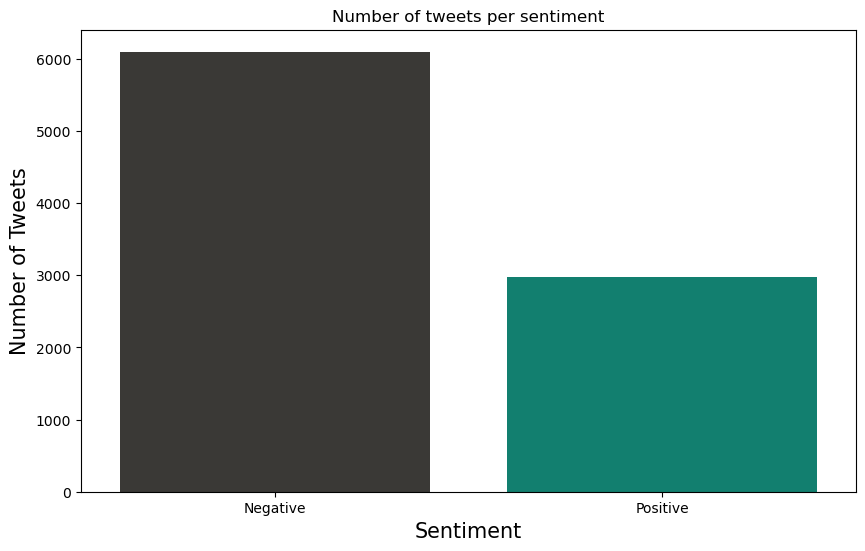

In [41]:
# Creating a bar chart for to visualize class imbalance
fig, ax = plt.subplots(figsize=(10,6))

# Defining custom colors 
custom_colors = ['#3B3935', '#00917C']

sns.countplot(data=df, x='sentiment', order=df['sentiment'].value_counts().index, palette=custom_colors)

ax.set_xlabel(xlabel = 'Sentiment', fontsize=15)
ax.set_ylabel(ylabel = 'Number of Tweets', fontsize=15)

ax.set_xticklabels(labels=['Negative', 'Positive'])

ax.set_title(f'Number of tweets per sentiment')

plt.show()

### 4. e) Performing a Train-Test Split

In [42]:
# Splitting df into X and y
X = df.drop('sentiment', axis=1)
y = df['sentiment']

In [43]:
X_train, X_test, y_train, _test = train_test_split(X, y, random_state=42, stratify=y)

In [45]:
X_train.head()

,tweet,product_or_company
8268,Huge shout out to GSDM &amp; Google for the kick ass party tonight! We had an unbelievable time. #SXSW,Google
945,#SXSW 20% of Google searches are for local information: Marissa Mayer. 6 million places claimed by their owners and logged by #Google,undefined
8832,free #sxsw playlist.. enjoy {link},undefined
7771,Awesome! RT @mention Yes! Gowalla wins best Andoid app at the Team Android Choice Awards. Thanks all! #sxsw,Android App
1643,#justmet @mention who worked for Apple for 25 years! #SXSW,Apple


In [46]:
y_train.head()

8268    positive
945     negative
8832    negative
7771    positive
1643    positive
Name: sentiment, dtype: object

* **Distribution of Target**

In [38]:
train_target_counts = pd.DataFrame(y_train.value_counts())
train_target_counts.index.name = 'target name'
train_target_counts.rename(columns={'sentiment': 'count'}, inplace=True)

In [39]:
train_target_counts

,count
target name,
No emotion toward brand or product,4041
Positive emotion,2233
Negative emotion,428
I can't tell,117


* **Visually Inspecting Features**

In [42]:
# Making a sample of 5 records to display the full text of each
train_sample = X_train.sample(5, random_state=22)
train_sample['label'] = [y_train[val] for val in train_sample.index]
train_sample.style.set_properties(**{'text-align': 'left'})

,tweet,product_or_company,label
1980,Is there an iPhone app that people use for #SXSW scheduling? This @mention is awesome but there isn't an app! #flummoxed,iPad or iPhone App,Positive emotion
8492,"who's sitting in the lobby of her hotel after 2am for free wifi so she can set up her new iPad? yeah, that's me. #sxsw",iPad,Positive emotion
2111,#sxsw Kawasaki says key to enchantment is likability of @mention trustworthiness of @mention & product of @mention,nan,No emotion toward brand or product
780,"Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw @mention",nan,No emotion toward brand or product
2487,"Now: Poked, Liked and Re-tweeted - a Google Love Story - Alisa (iCrossing). #sxsw #futurefifteen",nan,No emotion toward brand or product


## 4. or 5. ?

## 4. Data Preparation Continuity or Preprocessing?

### 4. e) Standardizing Case

Before starting any exploratory analysis, two fundamental data cleaning tasks will be performed on the text data: standardizing case and tokenizing. The first one will be standardizing.

### 4. f) Tokenizing

Before starting any exploratory analysis, two fundamental data cleaning tasks will be performed on the text data: standardizing case and tokenizing.

## 5. Modeling

*what modeling package(s) did you use, which model(s) within the package(s), and what tuning steps did you take?*
* For some projects there may be only one applicable package; you should still briefly explain why this was the appropriate choice

Text Text Text Text Text Text 

Text Text Text Text Text Text 

## 6. Evaluation

*how well did your final model perform?*
* Include one or more relevant metrics
 
* Be sure to briefly describe your validation approach

Text Text Text Text Text Text 

Text Text Text Text Text Text 

## 7. Findings & Recommendations

Text Text Text Text Text Text 

Text Text Text Text Text Text 

## 8. Limits & Next Steps

Text Text Text Text Text Text 

Text Text Text Text Text Text 